# Imports

In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_85450/2174054843.py:8: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
%%R
library(tidyverse)
library(dyno)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: dynfeature
Loading required package: dynguidelines
Loading required package: dynmethods
Loading required package: dynplot
Loading required package: dynwrap
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


# Loading Data

In [4]:
%%R
data <- readRDS("multifurcating_1.rds")

In [5]:
%%R
class(data)

[1] "dynwrap::with_prior"          "dynwrap::with_cell_waypoints"
[3] "dynwrap::with_prior"          "dynwrap::with_trajectory"    
[5] "dynwrap::with_expression"     "dynwrap::data_wrapper"       
[7] "list"                        


In [5]:
%%R
str(data)

List of 17
 $ id                   : chr "synthetic/splatter/multifurcating_1"
 $ cell_ids             : chr [1:920] "Cell1" "Cell2" "Cell3" "Cell4" ...
 $ cell_info            : NULL
 $ counts               : num [1:920, 1:1254] 48 0 0 18 31 38 11 31 19 17 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:920] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. ..$ : chr [1:1254] "Gene4247" "Gene4771" "Gene2697" "Gene3227" ...
 $ expression           : num [1:920, 1:1254] 5.25 0 0 4.26 4.36 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:920] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. ..$ : chr [1:1254] "Gene4247" "Gene4771" "Gene2697" "Gene3227" ...
 $ feature_info         : tibble [1,254 × 1] (S3: tbl_df/tbl/data.frame)
  ..$ feature_id: chr [1:1254] "Gene4247" "Gene4771" "Gene2697" "Gene3227" ...
 $ milestone_ids        : chr [1:9] "M1" "M3" "M6" "M8" ...
 $ milestone_network    : tibble [8 × 4] (S3: tbl_df/tbl/data.frame)
  ..$ from    : chr [1:8] "M1" "M3" "M6" "M3" ...
  ..

In [6]:
%%R
start_cell = data$prior_information$start_id

In [7]:
%%R
counts <- data$counts
expression <- data$expression

In [8]:
%%R
dataset <- wrap_expression(
  expression = expression,
  counts = counts
)

In [9]:
%%R
grouping <- (data$prior_information$groups_id)
grouping

# A tibble: 920 × 2
   cell_id group_id
   <chr>   <chr>   
 1 Cell1   M9      
 2 Cell10  M6      
 3 Cell100 M8      
 4 Cell101 M7      
 5 Cell102 M6      
 6 Cell103 M5      
 7 Cell104 M6      
 8 Cell105 M6      
 9 Cell106 M8      
10 Cell107 M5      
# ℹ 910 more rows
# ℹ Use `print(n = ...)` to see more rows


In [10]:
%%R
dataset <- add_prior_information(
    dataset,
    start_id = data$prior_information$start_id,
    end_id = data$prior_information$end_id,
    groups_id = data$prior_information$groups_id,
    end_n = data$prior_information$end_n,
)
dataset <- add_grouping(
    dataset,
    data$grouping
)

In [11]:
%%R
umap_dimred <- dyndimred::dimred_umap(dataset$expression)

Loading required namespace: uwot


In [12]:
%%R
library(dyndimred)
pca_dimred <- dimred_pca(
  dataset$expression
)

# DPT Model

In [13]:
%%R
dpt_model <- infer_trajectory(dataset, ti_dpt(), give_priors = c("start_id"))

In [172]:
%%R
names(dpt_model)

 [1] "id"                          "cell_ids"                   
 [3] "cell_info"                   "group_ids"                  
 [5] "grouping"                    "milestone_ids"              
 [7] "milestone_network"           "divergence_regions"         
 [9] "milestone_percentages"       "progressions"               
[11] "trajectory_type"             "directed"                   
[13] "dimred"                      "dimred_projected"           
[15] "dimred_milestones"           "dimred_segment_progressions"
[17] "dimred_segment_points"      


In [14]:
%%R
dpt_model <- add_dimred(
  dpt_model,
  dimred = pca_dimred,
  project_trajectory = FALSE,
  connect_segments = FALSE
)

In [15]:
%%R
traj <- project_trajectory(dpt_model, pca_dimred)

In [16]:
%%R
names(traj)

[1] "dimred_segment_points"       "dimred_segment_progressions"
[3] "dimred_milestones"          


In [17]:
%%R
head(traj$dimred_segment_points)

                             comp_1   comp_2
MILESTONE_BEGIN_WTip0_Tip1 1.159118 4.031978
W2                         1.152318 4.069384
W3                         1.145582 4.105567
W4                         1.138919 4.140567
W5                         1.132337 4.174426
W6                         1.125842 4.207182


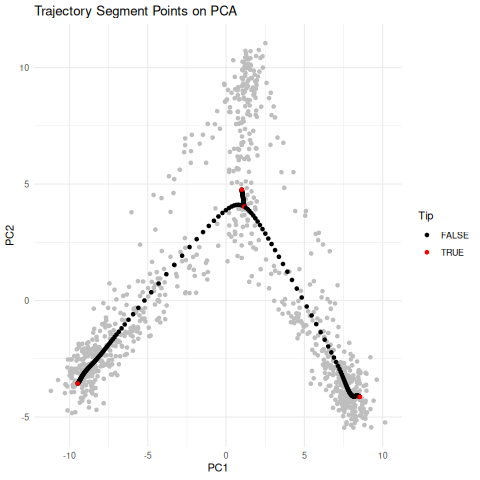

In [18]:
%%R
library(ggplot2)

# Convert pca_dimred to a data frame
pca_df <- as.data.frame(pca_dimred)
colnames(pca_df) <- c("PC1", "PC2")

# Convert traj$dimred_segment_points to a data frame
segment_points_df <- as.data.frame(traj$dimred_segment_points)
colnames(segment_points_df) <- c("PC1", "PC2")

# Add a column to indicate if the point name contains "Tip"
segment_points_df$Tip <- grepl("Tip", rownames(segment_points_df))

# Plot
ggplot() +
    geom_point(data = pca_df, aes(x = PC1, y = PC2), color = "grey") +
    geom_point(data = segment_points_df, aes(x = PC1, y = PC2, color = Tip)) +
    scale_color_manual(values = c("black", "red")) +
    theme_minimal() +
    labs(title = "Trajectory Segment Points on PCA",
             x = "PC1",
             y = "PC2",
             color = "Tip")

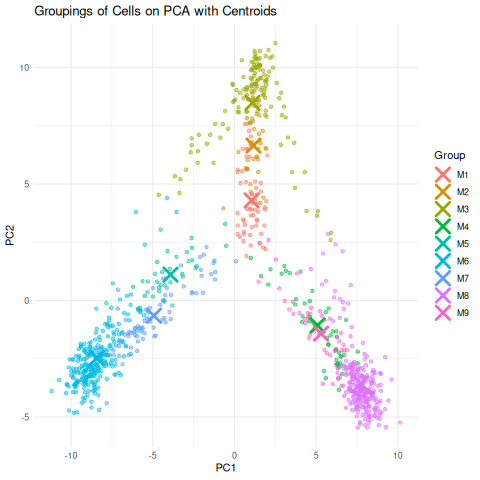

In [19]:
%%R
library(dplyr)
library(ggplot2)

# Check if grouping is defined
if (is.null(grouping)) {
  stop("The variable 'grouping' is not defined or is empty.")
}

# Convert grouping to a data frame
grouping_df <- as.data.frame(grouping)
colnames(grouping_df) <- c("Cell", "Group")

# Convert pca_dimred to a data frame
pca_df <- as.data.frame(pca_dimred)
colnames(pca_df) <- c("PC1", "PC2")
pca_df$Cell <- rownames(pca_df)

# Merge pca_df with grouping_df
merged_df <- merge(pca_df, grouping_df, by = "Cell")

# Calculate centroids for each group
centroids <- merged_df %>%
  group_by(Group) %>%
  summarize(PC1 = mean(PC1), PC2 = mean(PC2))

# Plot using ggplot2
ggplot(merged_df, aes(x = PC1, y = PC2, color = Group)) +
  geom_point(alpha = 0.5) +
  geom_point(data = centroids, aes(x = PC1, y = PC2, color = Group), size = 5, shape = 4, stroke = 2) +
  theme_minimal() +
  labs(title = "Groupings of Cells on PCA with Centroids",
       x = "PC1",
       y = "PC2",
       color = "Group")

In [20]:
%%R
centroids

# A tibble: 9 × 3
  Group   PC1    PC2
  <chr> <dbl>  <dbl>
1 M1     1.05  4.30 
2 M2     1.16  6.65 
3 M3     1.10  8.49 
4 M4     5.09 -1.07 
5 M5    -3.91  1.11 
6 M6    -8.42 -2.47 
7 M7    -4.93 -0.652
8 M8     7.74 -3.56 
9 M9     5.30 -1.42 


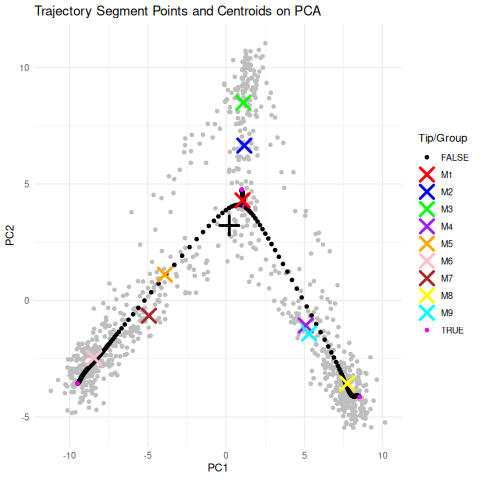

In [21]:
%%R
# Convert traj$dimred_segment_points to a data frame
segment_points_df <- as.data.frame(traj$dimred_segment_points)
colnames(segment_points_df) <- c("PC1", "PC2")

# Add a column to indicate if the point name contains "Tip"
segment_points_df$Tip <- grepl("Tip", rownames(segment_points_df))

# Plot
ggplot() +
    geom_point(data = pca_df, aes(x = PC1, y = PC2), color = "grey") +
    geom_point(data = pca_df[start_cell,], aes(x = PC1, y = PC2), color = "black", size = 5, shape = 3, stroke = 2) +
    geom_point(data = segment_points_df, aes(x = PC1, y = PC2, color = Tip)) +
    geom_point(data = centroids, aes(x = PC1, y = PC2, color = Group), size = 5, shape = 4, stroke = 2) +
    scale_color_manual(values = c("black", "red", "blue", "green", "purple", "orange", "pink", "brown", "yellow", "cyan", "magenta")) +
    theme_minimal() +
    labs(title = "Trajectory Segment Points and Centroids on PCA",
         x = "PC1",
         y = "PC2",
         color = "Tip/Group")

In [34]:
%%R
head(traj$dimred_segment_points)

                             comp_1   comp_2
MILESTONE_BEGIN_WTip0_Tip1 1.159118 4.031978
W2                         1.152318 4.069384
W3                         1.145582 4.105567
W4                         1.138919 4.140567
W5                         1.132337 4.174426
W6                         1.125842 4.207182


In [35]:
%%R
head(traj$dimred_segment_progressions,n=206)

# A tibble: 205 × 3
   from  to    percentage
   <chr> <chr>      <dbl>
 1 Tip0  Tip1      0     
 2 Tip0  Tip1      0.0332
 3 Tip0  Tip1      0.0664
 4 Tip0  Tip1      0.0996
 5 Tip0  Tip1      0.133 
 6 Tip0  Tip1      0.166 
 7 Tip0  Tip1      0.199 
 8 Tip0  Tip1      0.232 
 9 Tip0  Tip1      0.266 
10 Tip0  Tip1      0.299 
# ℹ 195 more rows
# ℹ Use `print(n = ...)` to see more rows


In [53]:
waypoints = 1
progressions = 1

In [54]:
%%R -o waypoints -o progressions
waypoints <- as.data.frame(traj$dimred_segment_points)
progressions <- as.data.frame(traj$dimred_segment_progressions)

In [55]:
progressions.set_index(waypoints.index, inplace=True)

In [56]:
waypoints['from'] = progressions['from']
waypoints['to'] = progressions['to']
waypoints['percentage'] = progressions['percentage']
waypoints

,comp_1,comp_2,from,to,percentage
MILESTONE_BEGIN_WTip0_Tip1,1.159118,4.031978,Tip0,Tip1,0.000000
W2,1.152318,4.069384,Tip0,Tip1,0.033213
W3,1.145582,4.105567,Tip0,Tip1,0.066427
W4,1.138919,4.140567,Tip0,Tip1,0.099640
W5,1.132337,4.174426,Tip0,Tip1,0.132853
...,...,...,...,...,...
W201,8.451356,-4.097969,Tip0,Tip3,0.958803
W202,8.472650,-4.106628,Tip0,Tip3,0.971096
W203,8.496181,-4.117620,Tip0,Tip3,0.983388
W204,8.522182,-4.131157,Tip0,Tip3,0.995680


In [65]:
milestones = 1

In [66]:
%%R -o milestones
milestones <- as.data.frame(traj$dimred_milestones)

In [ ]:
milestones

,comp_1,comp_2
Tip0,1.159118,4.031978
Tip1,0.997855,4.759664
Tip2,-9.478539,-3.562463
Tip3,8.531939,-4.136552


In [ ]:
for tip in milestones.index:
    milestones[tip] = np.sqrt((milestones['comp_1'] - milestones.loc[tip, 'comp_1'])**2 + (milestones['comp_2'] - milestones.loc[tip, 'comp_2'])**2)
milestones

,comp_1,comp_2,Tip0,Tip1,Tip2,Tip3
Tip0,1.159118,4.031978,0.000000,0.555533,170.835283,121.083379
Tip1,0.997855,4.759664,0.555533,0.000000,179.012627,135.905090
Tip2,-9.478539,-3.562463,170.835283,179.012627,0.000000,324.706909
Tip3,8.531939,-4.136552,121.083379,135.905090,324.706909,0.000000


In [76]:
for w in waypoints.index:
    waypoints.loc[w,'distance_from'] = waypoints.loc[w,'percentage'] * milestones.loc[waypoints.loc[w,'from'],waypoints.loc[w,'to']]
    waypoints.loc[w,'distance_to'] = (1-waypoints.loc[w,'percentage']) * milestones.loc[waypoints.loc[w,'from'],waypoints.loc[w,'to']]
waypoints

,comp_1,comp_2,from,to,percentage,distance_from,distance_to
MILESTONE_BEGIN_WTip0_Tip1,1.159118,4.031978,Tip0,Tip1,0.000000,0.000000,0.555533
W2,1.152318,4.069384,Tip0,Tip1,0.033213,0.018451,0.537082
W3,1.145582,4.105567,Tip0,Tip1,0.066427,0.036902,0.518631
W4,1.138919,4.140567,Tip0,Tip1,0.099640,0.055353,0.500180
W5,1.132337,4.174426,Tip0,Tip1,0.132853,0.073804,0.481728
...,...,...,...,...,...,...,...
W201,8.451356,-4.097969,Tip0,Tip3,0.958803,116.095143,4.988236
W202,8.472650,-4.106628,Tip0,Tip3,0.971096,117.583542,3.499837
W203,8.496181,-4.117620,Tip0,Tip3,0.983388,119.071941,2.011438
W204,8.522182,-4.131157,Tip0,Tip3,0.995680,120.560341,0.523038


In [165]:
waypoints.loc['W9']

comp_1           1.106935
comp_2           4.299202
from                 Tip0
to                   Tip1
percentage       0.265706
distance_from    0.147608
distance_to      0.407924
Name: W9, dtype: object

In [151]:
milestone_network = pd.DataFrame(columns=['from', 'to', 'distance'])
temp = set()
for i, row in waypoints.iterrows():
    if (row['from'], row['to']) not in temp:
        temp.add((row['from'], row['to']))
        milestone_network.loc[len(milestone_network)+1] = {'from': row['from'], 'to': row['to'], 'distance': float(milestones.loc[row['from'], row['to']])}
milestone_network

,from,to,distance
1,Tip0,Tip1,0.555533
2,Tip0,Tip2,170.835283
3,Tip0,Tip3,121.083379


In [168]:
adj = {}
for m in milestones.index:
    adj[m] = {}
    adj[m][m] = 0  
for i, row in milestone_network.iterrows():
    adj[row['from']][row['to']] = row['distance']
adj

{'Tip0': {'Tip0': 0,
  'Tip1': 0.5555326619044978,
  'Tip2': 170.8352828184493,
  'Tip3': 121.0833791400634},
 'Tip1': {'Tip1': 0},
 'Tip2': {'Tip2': 0},
 'Tip3': {'Tip3': 0}}

In [113]:
new_milestones = 1

In [121]:
%%R -o new_milestones
new_milestones <- as.data.frame(centroids)

In [123]:
new_milestones.rename(columns={'PC1': 'comp_1', 'PC2': 'comp_2'}, inplace=True)
new_milestones.drop(columns=['Group'], inplace=True)
new_milestones.index = ['M' + str(i+1) for i in range(len(new_milestones))]
new_milestones

,comp_1,comp_2
M1,1.048368,4.298450
M2,1.164435,6.649593
M3,1.102038,8.489153
M4,5.085394,-1.068862
M5,-3.912888,1.111688
M6,-8.423240,-2.468523
M7,-4.930882,-0.652197
M8,7.735236,-3.563896
M9,5.298591,-1.419175


In [128]:
cells = 1

In [129]:
%%R -o cells
cells <- as.data.frame(pca_dimred)

In [ ]:
# dist = pd.DataFrame(index=cells.index, columns=waypoints.index)
# for cell in cells.index:
#     for waypoint in waypoints.index:
#         dist.loc[cell,waypoint] = np.sqrt((cells.loc[cell,'comp_1'] - waypoints.loc[waypoint,'comp_1'])**2 + (cells.loc[cell,'comp_2'] - waypoints.loc[waypoint,'comp_2'])**2)
# closest = pd.DataFrame(index=cells.index, columns=['closest_waypoint', 'distance'])
# for cell in dist.index:
#     min_distance = dist.loc[cell].min()
#     closest_waypoint = dist.loc[cell].idxmin()
#     closest.loc[cell] = [closest_waypoint, min_distance]

In [126]:
dist = pd.DataFrame(index=new_milestones.index, columns=waypoints.index)
for m in new_milestones.index:
    for waypoint in waypoints.index:
        dist.loc[m,waypoint] = np.sqrt((new_milestones.loc[m,'comp_1'] - waypoints.loc[waypoint,'comp_1'])**2 + (new_milestones.loc[m,'comp_2'] - waypoints.loc[waypoint,'comp_2'])**2)
dist

,MILESTONE_BEGIN_WTip0_Tip1,W2,W3,W4,W5,W6,W7,W8,W9,W10,...,W196,W197,W198,W199,W200,W201,W202,W203,W204,MILESTONE_END_WTip0_Tip3
M1,0.28857,0.251549,0.215997,0.182007,0.149775,0.119716,0.09274,0.07093,0.058572,0.060176,...,11.126919,11.136714,11.147979,11.161034,11.176229,11.19393,11.214513,11.238334,11.265708,11.276218
M2,2.61762,2.580237,2.544096,2.509155,2.475375,2.442716,2.41114,2.380612,2.351094,2.322554,...,12.924948,12.933356,12.943236,12.9549,12.96869,12.984964,13.004087,13.02641,13.052242,13.062199
M3,4.45754,4.420055,4.383802,4.348742,4.314833,4.282037,4.250316,4.219633,4.189954,4.161243,...,14.519691,14.527308,14.536388,14.547238,14.560191,14.575599,14.593821,14.6152,14.64004,14.649637
M4,6.436941,6.470754,6.503601,6.535504,6.566485,6.596567,6.625771,6.654119,6.681635,6.70834,...,4.455926,4.466808,4.479146,4.493265,4.509514,4.528265,4.549893,4.574756,4.603169,4.614044
M5,5.852635,5.865516,5.878047,5.890235,5.90209,5.913619,5.92483,5.935732,5.946332,5.956639,...,13.334395,13.347732,13.362336,13.378516,13.396609,13.416969,13.439954,13.465907,13.495125,13.506212
M6,11.57921,11.594635,11.609523,11.623897,11.637776,11.651181,11.664129,11.676639,11.688728,11.70041,...,16.869278,16.883509,16.898727,16.915199,16.933217,16.953085,16.975114,16.999598,17.026793,17.037032
M7,7.683072,7.700562,7.717496,7.733892,7.749769,7.765145,7.780036,7.79446,7.808431,7.821965,...,13.734604,13.748536,13.763611,13.780123,13.798388,13.818742,13.841523,13.867054,13.895614,13.906412
M8,10.047021,10.07977,10.111587,10.142492,10.172507,10.201654,10.229954,10.257428,10.284098,10.309987,...,0.817961,0.82939,0.842319,0.857059,0.873947,0.893343,0.915608,0.941088,0.970087,0.981158
M9,6.844728,6.878652,6.911603,6.943602,6.974672,7.004836,7.034117,7.062538,7.090121,7.116889,...,4.0636,4.074737,4.087322,4.101679,4.118159,4.137132,4.158973,4.184039,4.212646,4.223586


In [127]:
closest = pd.DataFrame(index=new_milestones.index, columns=['closest_waypoint', 'distance'])
for m in dist.index:
    min_distance = dist.loc[m].min()
    closest_waypoint = dist.loc[m].idxmin()
    closest.loc[m] = [closest_waypoint, min_distance]
closest

,closest_waypoint,distance
M1,W9,0.058572
M2,MILESTONE_END_WTip0_Tip1,1.897256
M3,MILESTONE_END_WTip0_Tip1,3.730944
M4,W144,0.568598
M5,W51,0.099188
M6,W78,0.135983
M7,W54,0.712103
M8,W161,0.097602
M9,W145,0.615269


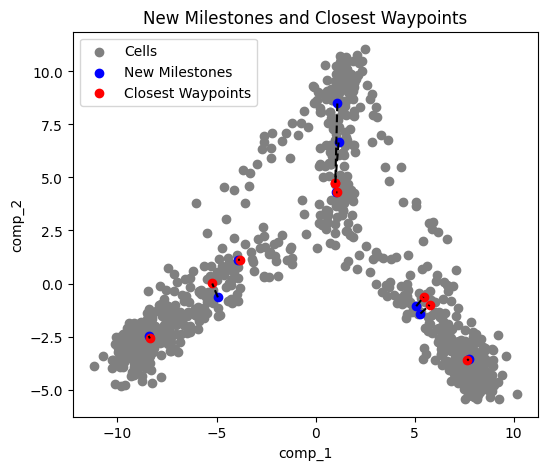

In [130]:
import random

# Plot all cells
plt.figure(figsize=(6, 5))
plt.scatter(cells['comp_1'], cells['comp_2'], color='grey', label='Cells')

# Plot the new milestones and their closest waypoints
for m in new_milestones.index:
    m_coords = new_milestones.loc[m]
    waypoint = closest.loc[m, 'closest_waypoint']
    waypoint_coords = waypoints.loc[waypoint]
    
    # Plot the m
    plt.scatter(m_coords['comp_1'], m_coords['comp_2'], color='blue', label='New Milestones' if m == new_milestones.index[0] else "")
    
    # Plot the closest waypoint
    plt.scatter(waypoint_coords['comp_1'], waypoint_coords['comp_2'], color='red', label='Closest Waypoints' if m == new_milestones.index[0] else "")
    
    # Draw a line between the m and the closest waypoint
    plt.plot([m_coords['comp_1'], waypoint_coords['comp_1']], [m_coords['comp_2'], waypoint_coords['comp_2']], color='black', linestyle='--')

plt.xlabel('comp_1')
plt.ylabel('comp_2')
plt.title('New Milestones and Closest Waypoints')
plt.legend()
plt.show()

In [171]:
def milestones_distance(m1,m2,closest,waypoints,adj):
    if m1==m2: return 0
    distance = 0
    w1 = closest.loc[m1,'closest_waypoint']
    w2 = closest.loc[m2,'closest_waypoint']
    wd1 = closest.loc[m1,'distance']
    wd2 = closest.loc[m2,'distance']
    distance += (wd1+wd2)
    t1 = waypoints.loc[w1,'to']
    t2 = waypoints.loc[w2,'from']
    d1 = waypoints.loc[w1,'distance_to']
    d2 = waypoints.loc[w2,'distance_from']
    distance += (d1+d2)
    if t1 in adj:
        if t2 in adj[t1]:
            distance += adj[t1][t2]
            return distance
    return 0